# Car brand recognition


In [76]:
#import the needed libraries
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras import metrics

**The stanford cars dataset contains of 2 folders with pictures and 1 folder with the data** <br>
>The 2 folders with the pictures are:
>* cars_train where the images that have the brand of the car are located
>* cars_test which do not have a corresponding class and can be used only to test the model after it is fitted
>The folder with the data contains:
>* cars_train_annos.mat which contains the min and max bounding box values of each picture in the train folder and it's corresponding class aka car brand and model
>* cars_test_annos.mat which contains the min and max bounding box values of each picture in the test folder
>* cars_meta.mat which contains the different car models and their corresponding class numbers

In [4]:
#Cars meta is the classification aka the different car models in the dataset
cars_meta = scipy.io.loadmat('data/car_devkit/car_devkit/devkit/cars_meta.mat')

In [5]:
class_names = cars_meta['class_names']  
class_names = np.transpose(class_names)
print('class_names.shape: ' + str(class_names.shape))
print('Sample class_name: [{}]'.format(class_names[39][0][0]))

class_names.shape: (196, 1)
Sample class_name: [Bentley Arnage Sedan 2009]


In [6]:
#Processing train data...
cars_annos = scipy.io.loadmat('data/car_devkit/car_devkit/devkit/cars_train_annos.mat')
annotations = cars_annos['annotations']
annotations = np.transpose(annotations)

In [7]:
#Processing test data...
cars_test_annos = scipy.io.loadmat('data/car_devkit/car_devkit/devkit/cars_test_annos.mat')
annotations_test = cars_test_annos['annotations']
annotations_test = np.transpose(annotations_test)

In [5]:
#see different classes aka car models
for t in class_names:
    print(t[0][0])

AM General Hummer SUV 2000
Acura RL Sedan 2012
Acura TL Sedan 2012
Acura TL Type-S 2008
Acura TSX Sedan 2012
Acura Integra Type R 2001
Acura ZDX Hatchback 2012
Aston Martin V8 Vantage Convertible 2012
Aston Martin V8 Vantage Coupe 2012
Aston Martin Virage Convertible 2012
Aston Martin Virage Coupe 2012
Audi RS 4 Convertible 2008
Audi A5 Coupe 2012
Audi TTS Coupe 2012
Audi R8 Coupe 2012
Audi V8 Sedan 1994
Audi 100 Sedan 1994
Audi 100 Wagon 1994
Audi TT Hatchback 2011
Audi S6 Sedan 2011
Audi S5 Convertible 2012
Audi S5 Coupe 2012
Audi S4 Sedan 2012
Audi S4 Sedan 2007
Audi TT RS Coupe 2012
BMW ActiveHybrid 5 Sedan 2012
BMW 1 Series Convertible 2012
BMW 1 Series Coupe 2012
BMW 3 Series Sedan 2012
BMW 3 Series Wagon 2012
BMW 6 Series Convertible 2007
BMW X5 SUV 2007
BMW X6 SUV 2012
BMW M3 Coupe 2012
BMW M5 Sedan 2010
BMW M6 Convertible 2010
BMW X3 SUV 2012
BMW Z4 Convertible 2012
Bentley Continental Supersports Conv. Convertible 2012
Bentley Arnage Sedan 2009
Bentley Mulsanne Sedan 2011
Ben

In [8]:
#Take a look at how an element looks
annotations[221]

array([(array([[89]], dtype=uint8), array([[58]], dtype=uint8), array([[545]], dtype=uint16), array([[338]], dtype=uint16), array([[196]], dtype=uint8), array(['00222.jpg'], dtype='<U9'))],
      dtype=[('bbox_x1', 'O'), ('bbox_y1', 'O'), ('bbox_x2', 'O'), ('bbox_y2', 'O'), ('class', 'O'), ('fname', 'O')])

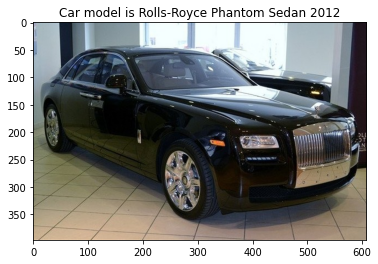

In [9]:
#Look into the images and the class name
index = 210
img = mpimg.imread(f'data/cars_train/cars_train/{annotations[index][0][5][0]}')
plt.imshow(img)
plt.title(f'Car model is {class_names[annotations[index][0][4][0][0]][0][0]}')
plt.show()

# Data preparation before modeling

**I will not make use of the bounding box values provided in the data. Instead I will only use the picture as a feature. The picture will be represented by an array value.**

In [10]:
annotations = annotations.flatten()
annotations_test = annotations_test.flatten()

In [11]:
#get the x and y which in this case are the picture as an array and the car model
x = []
y = []
for annotation in annotations:
    picture_array = mpimg.imread(f'data/cars_train/cars_train/{annotation[5][0]}')
    picture_array = cv2.resize(picture_array, (32,32)).astype('float32')/255                    
    x.append(picture_array)
    y.append(annotation[4][0])

The array is resized and the numbers are scaled to be between 0 and 1 which also makes drops the quality of the picture

In [12]:
#this is the testing data which will be used after the model is trained  
X_test = []
for annotation in annotations_test:
    picture_array = mpimg.imread(f'data/cars_test/cars_test/{annotation[4][0]}')
    picture_array = cv2.resize(picture_array, (32,32)).astype('float32')/255
    X_test.append(picture_array)

In [13]:
#Some of the pictures in the data appear to be black and white which make the shape of the array different from the others. That's why the next 2 cell will display the shapes.
checkShapes = []
for t in x:
    checkShapes.append(t.shape)

In [14]:
#See how many of the arrays have different shape
from collections import Counter
print(Counter(checkShapes).values())
print(Counter(checkShapes).keys())

dict_values([8126, 18])
dict_keys([(32, 32, 3), (32, 32)])


In [15]:
#I tried multiple ways to convert the 32,32 array into 32,32,3 but none of them worked so I will have to delete the 18 rows of data where the images are black and white
for t in x:
    if t.shape == (32,32):
        index = x.index(t)
        del x[index]
        del y[index]

<ipython-input-15-324efd80797c>:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  index = x.index(t)


In [16]:
#Check if now everything is the same shape
checkShapes = []
for t in x:
    checkShapes.append(t.shape)
print(Counter(checkShapes).values())
print(Counter(checkShapes).keys())

dict_values([8126])
dict_keys([(32, 32, 3)])


Text(0.5, 1.0, 'Bugatti Veyron 16.4 Coupe 2009')

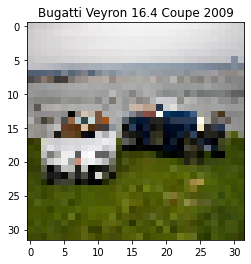

In [17]:
#Visualise a picture and it's car model to see how the pixels dropped and to make sure after the deletion the indexex have not changed somehow
index = 1332
plt.imshow(x[index])
plt.title(class_names[y[index][0]][0][0])

In [18]:
#I can tell for sure that the picture above is the given car
#Now that all the arrays have the same shape we can convert the list into an array and then split the data intro train and test
x = np.array(x)
y = np.array(y)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [20]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6500, 32, 32, 3), (6500, 1), (1626, 32, 32, 3), (1626, 1))

In [21]:
#Apply categorical encoding since we are using classification
y_train_one_hot = to_categorical(y_train)

In [22]:
y_test_one_hot = to_categorical(y_test)

In [23]:
#Create the models architecture
model = Sequential()

#Add the first layer
model.add(Conv2D(64, (5,5), activation='relu', input_shape=(32,32,3)))

#Add a pooling layer
model.add(MaxPooling2D(pool_size = (2,2)))

#Add a second convolution layer
model.add(Conv2D(64, (5,5), activation='relu'))

#Add a second pooling layer
model.add(MaxPooling2D(pool_size = (2,2)))

#Add a flattening layer - reduce to linear array
model.add(Flatten())

#Create a layer with 1970 neurons
model.add(Dense(1970, activation='relu'))

#Add a dropout layer
model.add(Dropout(0.5))

#Add a layer with 985 neurons
model.add(Dense(985, activation='relu'))

#Add a dropout layer
model.add(Dropout(0.5))

#Add a layer with 591 neurons
model.add(Dense(591, activation='relu'))

#Add a layer with 197 neurons - Softmax will be used so that the output values add to 1 - I have tried different activaiton but this one I think is the most appropriate
model.add(Dense(197, activation='softmax'))

In [24]:
#Compile the model
model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [25]:
#Train the model
hist = model.fit(x_train, y_train_one_hot,
                 batch_size=256,
                 epochs = 60,
                 validation_split = 0.2)

Epoch 1/60
21/21 [==============================] - 5s 221ms/step - loss: 5.2927 - accuracy: 0.0058 - val_loss: 5.2849 - val_accuracy: 0.0023
Epoch 2/60
21/21 [==============================] - 4s 180ms/step - loss: 5.2793 - accuracy: 0.0050 - val_loss: 5.2903 - val_accuracy: 0.0038
Epoch 3/60
21/21 [==============================] - 4s 183ms/step - loss: 5.2716 - accuracy: 0.0086 - val_loss: 5.2891 - val_accuracy: 0.0108
Epoch 4/60
21/21 [==============================] - 4s 181ms/step - loss: 5.2645 - accuracy: 0.0094 - val_loss: 5.2841 - val_accuracy: 0.0108
Epoch 5/60
21/21 [==============================] - 4s 185ms/step - loss: 5.2565 - accuracy: 0.0078 - val_loss: 5.2592 - val_accuracy: 0.0131
Epoch 6/60
21/21 [==============================] - 4s 196ms/step - loss: 5.2125 - accuracy: 0.0077 - val_loss: 5.1920 - val_accuracy: 0.0138
Epoch 7/60
21/21 [==============================] - 4s 195ms/step - loss: 5.1280 - accuracy: 0.0109 - val_loss: 5.1465 - val_accuracy: 0.0162
Epoch 

In [26]:
#Evaluate model on test dataset
model.evaluate(x_test,y_test_one_hot)

51/51 [==============================] - 0s 8ms/step - loss: 11.7590 - accuracy: 0.0363


[11.758994102478027, 0.036285363137722015]

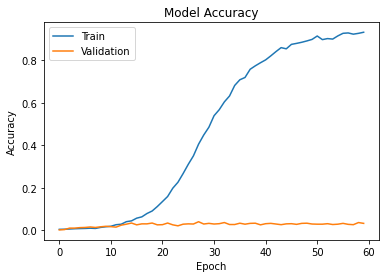

In [27]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

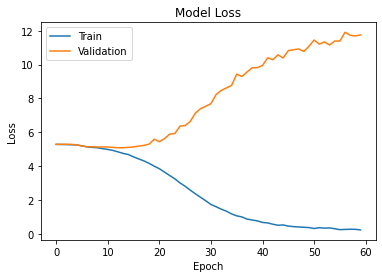

In [28]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

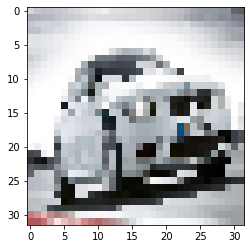

In [65]:
#Visualize a random car from the testing picture to see what will the model predict - this appears to be a BMW  
plt.imshow(X_test[2816])
plt.show()

In [61]:
#Get the model predictions on the image above
predictions = model.predict(np.array([X_test[2816]]))      
#Show predictions
predictions

array([[7.83844933e-25, 5.13375916e-18, 2.37815990e-03, 3.34286538e-04,
        2.98818224e-04, 8.52158701e-05, 7.75017328e-10, 4.16277151e-04,
        1.36112897e-06, 1.43814823e-05, 8.85883492e-05, 9.09395579e-14,
        2.18090918e-07, 1.29478780e-04, 8.38485994e-06, 2.69470784e-05,
        2.07491166e-06, 2.76976930e-09, 2.94061303e-10, 1.62741999e-04,
        9.22352774e-05, 3.34620438e-08, 9.00599480e-06, 1.37311203e-04,
        1.03337720e-06, 1.10864651e-08, 3.01857173e-01, 1.79969184e-02,
        1.99843021e-06, 2.45065621e-06, 1.48668373e-03, 7.85094089e-05,
        5.16859111e-10, 6.76292984e-06, 1.76889189e-02, 9.03393011e-05,
        2.99080391e-03, 1.96758236e-08, 2.79078929e-04, 5.61446723e-06,
        1.70571584e-05, 1.18868367e-03, 2.26678164e-03, 4.77237673e-03,
        4.33214227e-05, 1.68131322e-08, 1.00060170e-05, 2.01204884e-07,
        2.20140833e-11, 6.80687492e-07, 3.86578698e-08, 2.04990455e-03,
        2.24502237e-05, 1.12901979e-11, 7.06865461e-14, 7.923331

In [62]:
#Sort the predictions from least to greatest
list_index = list(range(0,197))
p = predictions

for i in range(197):
    for j in range(197):
        if p[0][list_index[i]] > p[0][list_index[j]]:
            temp = list_index[i]
            list_index[i] = list_index[j]
            list_index[j] = temp
print(list_index)

[185, 26, 141, 137, 27, 34, 184, 43, 36, 2, 42, 51, 134, 150, 30, 41, 163, 7, 115, 164, 140, 190, 3, 4, 162, 38, 102, 19, 23, 13, 20, 35, 10, 5, 144, 196, 175, 31, 177, 179, 63, 44, 128, 165, 192, 188, 173, 80, 15, 52, 187, 40, 138, 9, 182, 181, 171, 46, 22, 14, 167, 33, 39, 59, 195, 81, 29, 78, 16, 28, 139, 101, 82, 8, 168, 180, 24, 157, 49, 56, 129, 166, 191, 73, 127, 67, 12, 47, 170, 107, 174, 105, 135, 104, 57, 176, 172, 61, 131, 50, 21, 93, 110, 126, 120, 37, 45, 97, 83, 98, 25, 70, 130, 76, 160, 112, 77, 119, 154, 17, 158, 161, 194, 108, 155, 156, 92, 68, 89, 178, 142, 117, 6, 99, 88, 143, 189, 86, 32, 159, 62, 95, 169, 87, 18, 66, 94, 136, 69, 148, 79, 58, 152, 109, 116, 72, 124, 186, 133, 48, 149, 193, 53, 85, 100, 118, 111, 145, 121, 64, 74, 60, 90, 183, 151, 123, 11, 75, 55, 54, 132, 96, 146, 147, 122, 91, 106, 114, 103, 65, 125, 113, 153, 71, 1, 84, 0]


In [63]:
#print first 5 most likely classes by predictions
for i in range(5):
    print(class_names[list_index[i]][0][0], ':', round(predictions[0][list_index[i]] * 100), '%')


Toyota Sequoia SUV 2012 : 52 %
BMW 1 Series Convertible 2012 : 30 %
Infiniti QX56 SUV 2011 : 8 %
Hyundai Sonata Sedan 2012 : 2 %
BMW 1 Series Coupe 2012 : 2 %


2 out of the 5 most likely classes are indeed a BMW but the accuracy is not very good. 

**Evaluate on mean squared error**

In [72]:
y_pred = model.predict(x_test)

In [82]:
mse = metrics.MeanSquaredError()
mse.update_state(y_test, y_pred)
mse.result().numpy()

12769.323

The result is expectedly not good.

> **I played with the layers and neurons, added more epochs and changed the architecture of the model a couple of times but could not get very accurate results. The reason is most likely the many categories - 197. A possible solution to try to only predict car brands, which would mean removing the year and model. Afterwards the same brands should be combined into one categorical number and all the class numbers in the train data will have to switch to it.**

>**The code below displays an example of every class model, it appears that some of the data is incorrect - the labels do not match the picture, this is a problem with the data that I explain in the next notebook where I also reduce the categories to see if I 
can get better results and also fix an issue with the data.** <br> <br>
PS: no need to scroll to the bottom - there is no more code in this notebook. 

In [85]:
#define function that returns the indexes of an item in a list
def list_duplicates_of(seq,item):
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs

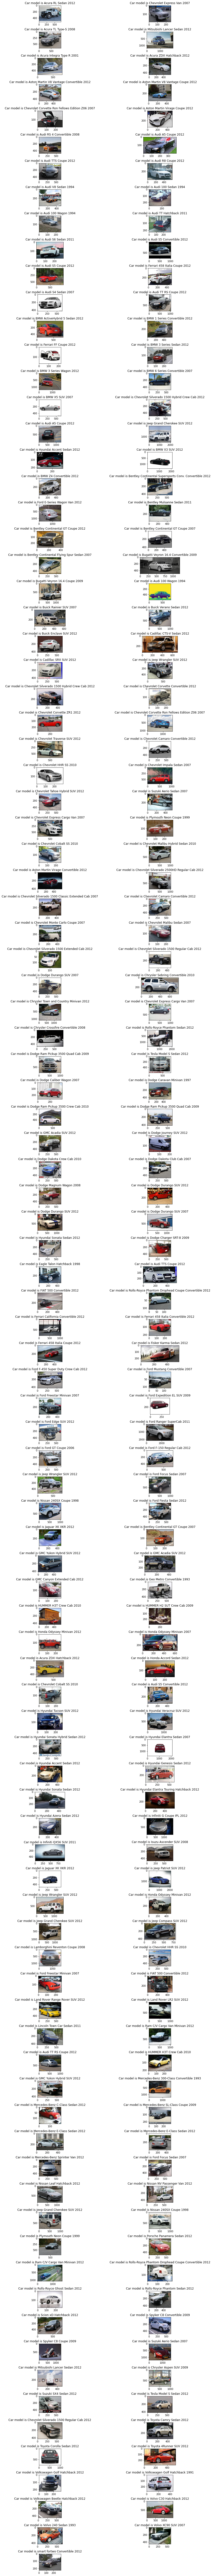

In [104]:
fig = plt.figure(figsize=(15, 200))
# setting values to rows and column variables
rows = 100
columns = 2
fig.subplots_adjust(hspace=0.6)

for i in range(0,196):
    dupl = list_duplicates_of(list(y), i)
    if len(dupl) != 0:
        img = mpimg.imread(f'data/cars_train/cars_train/{annotations[dupl[0]][5][0]}')
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.title(f'Car model is {class_names[annotations[dupl[0]][4][0]][0][0][0]}')
        #plt.show()